In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from torchvision.transforms import functional as TF
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Image as IPImage

from wiring_efficiency_utils import *
from neuralsheet import *
from map_plotting import *

%load_ext autoreload
%autoreload 2

In [2]:
def generate_euclid(number, size):
    # Create a grid of coordinates (x, y) for the centers
    lin_centers = torch.linspace(-size / 2, size / 2, number)
        
    x_centers, y_centers = torch.meshgrid(lin_centers, lin_centers, indexing='ij')
    
    # Create a grid of coordinates (x, y) for a single Gaussian of size MxM
    lin = torch.linspace(-size / 2, size / 2, size)
    x, y = torch.meshgrid(lin, lin, indexing='ij')
    
    # Flatten the center coordinates~ to easily use broadcasting
    x_centers_flat = x_centers.reshape(-1, 1, 1)
    y_centers_flat = y_centers.reshape(-1, 1, 1)
    
    # Calculate the squared distance for each Gaussian center to each point in the MxM grid
    dist_squared = (x - x_centers_flat) ** 2 + (y - y_centers_flat) ** 2
    
    dists = torch.sqrt(dist_squared).view(number**2, size**2)
    
    return dists

In [3]:
def get_spectral_entropy(codes):
    
    codes = codes.view(codes.shape[0], 1, c_size, c_size).mean(0, keepdim=True)
    fft = torch.fft.fft2(codes).abs()
    spectral_dist = fft / (fft.sum([1,2,3], keepdim=True) + 1e-11)
    spectral_entropy = spectral_dist * torch.log(spectral_dist + 1e-11)
    spectral_entropy = - spectral_entropy.sum()
            
    return fft.mean()

In [4]:
device = 'cuda'

i_size = 50
c_size = 30

aff_w = torch.randn(c_size**2, i_size**2) / np.sqrt(c_size)
lat_w = torch.eye(c_size**2)
eff_w = torch.randn(i_size**2, c_size**2) / np.sqrt(c_size)
b = torch.zeros(c_size**2)

aff_w = nn.Parameter(aff_w.to(device))
lat_w = nn.Parameter(lat_w.to(device))
eff_w = nn.Parameter(eff_w.to(device))
b = nn.Parameter(b.to(device))

aff_euclid = generate_euclid(c_size, i_size).to(device)
eff_euclid = generate_euclid(i_size, c_size).to(device)
lat_euclid = generate_euclid(c_size, c_size).to(device)

mean_bce = 0
bce_beta = 1e-2

batch_size = 128
num_workers = 4 
root_dir = './input_stimuli' 
dataloader = create_dataloader(root_dir, i_size, batch_size, num_workers)
optim = torch.optim.Adam([aff_w, eff_w, lat_w, b], lr = 2e-3)

In [5]:
def forward(aff_w, lat_w, eff_w, b, x, iters=10):
    
    afferent = x @ aff_w.T
    code = torch.relu(afferent)
    
    for i in range(iters):
        
        lateral = code @ lat_w.T
        z = afferent + lateral
        code = torch.relu(z - z.detach()**2) * 4
        #code = code - code.detach()**2
        #code_max = code.detach().max(1, keepdim=True)[0]
        #code_max[code_max<1] = 1
        #code = code / code_max
        
    efferent = code @ eff_w.T
    efferent = torch.sigmoid(efferent)
    
    return code, efferent

In [386]:
def get_loss(reco_input, true_input, aff_w, aff_euclid, lat_euclid, eff_euclid, code):
    
    bce = true_input * torch.log(reco_input + 1e-11) + (1-true_input) * torch.log(1 - reco_input + 1e-11)
    bce = - bce.mean()
    
    aff_locality = (aff_w.abs() * aff_euclid).sum()
    eff_locality = (eff_w.abs() * eff_euclid).sum()
    lat_locality = (lat_w.abs() * lat_euclid).sum()
    locality = aff_locality + lat_locality + eff_locality
    
    se = get_spectral_entropy(code)
    
    mean_acts = code.mean(0)
    mean_acts = mean_acts / (mean_acts.sum() + 1e-11)
    homeo = mean_acts * torch.log(mean_acts + 1e-11)
    homeo = - homeo.sum()
    
    sparsity = code.mean()
    
    loss = bce -5e-2*code.std() + 5e-7*locality + 0*se + 0*sparsity
                    
    return loss, bce

In [ ]:
epochs = 100

for e in range(epochs):
    
    batch_progress = tqdm(dataloader, leave=False)
    for batch in batch_progress:

        batch = batch[:,:1].to(device).view(batch.shape[0], -1)

        code, efferent = forward(aff_w, lat_w, eff_w, b, batch)

        loss, bce = get_loss(efferent, batch, aff_w, aff_euclid, lat_euclid, eff_euclid, code)
        
        mean_bce = (1-bce_beta)*mean_bce + bce_beta*bce.detach()

        optim.zero_grad()
        loss.backward()
        optim.step()

        batch_progress.set_description('Loss: {:.3f}, BCE:{:.3f}'.format(loss, mean_bce))


Loss: 7.324, BCE:0.110:   3%|▌                  | 9/302 [00:02<01:08,  4.28it/s]

tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)


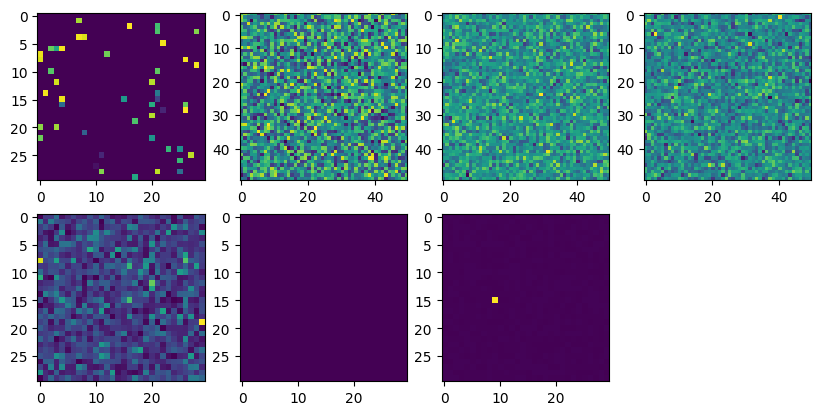

In [407]:
print(code.max())

s = random.randint(0, batch.shape[0]-1)
n = random.randint(0, c_size**2-1)

plt.figure(figsize=(10,10))
plt.subplot(4,4,1)
plt.imshow(code[s].detach().cpu().view(c_size,c_size))

plt.subplot(4,4,2)
plt.imshow(efferent[s].detach().cpu().view(i_size,i_size))

plt.subplot(4,4,3)
plt.imshow(aff_w[n].detach().cpu().view(i_size,i_size))

plt.subplot(4,4,4)
plt.imshow(eff_w[:,n].detach().cpu().view(i_size,i_size))

plt.subplot(4,4,5)
mean_code = code.mean([0]).detach().cpu().view(c_size,c_size)
mean_code[0,0] = 0
#mean_code[-1,-1] = 1
plt.imshow(mean_code)

plt.subplot(4,4,6)
plt.imshow(b.detach().cpu().view(c_size,c_size))

plt.subplot(4,4,7)
plt.imshow(lat_w[n].detach().cpu().view(c_size,c_size))

plt.show()